In [1]:
# Author: Helene Genet, UAF
# Creation date: Jan. 25 2022
# Purpose: this script generates outputs of soil layer variables for standardized depth to facilitate benchmarking and data analysis

import sys
import os
from os.path import exists
import pandas as pd
import datetime
import numpy as np
import xarray as xr
import netCDF4 as nc
import cftime

In [47]:
sc = 'tr'
#inpath = "/data/input-catalog/caribou-poker/"
inpath = '/data/workflows/poker_flats_test/output/'
outpath = "/work/scripts/caribou-poker-exp/soil_layer_synthesis/"
timeres = 'monthly'
var = 'LWCLAYER'
depthlist = [0.10, 0.20]

In [60]:
### read the variables passed from the bash


fvar = var + "_" + timeres + "_" + sc + ".nc"
fsoil = "LAYERDZ_monthly_" + sc + ".nc"

ltype = "LAYERTYPE_monthly_" + sc + ".nc"

### read the netcdf output files and compute year from the time dimension
data = xr.open_dataset(os.path.join(inpath + fvar ))
data = data.to_dataframe()
data.reset_index(inplace=True)
data.dtypes
data['time'] = data['time'].astype('|S80')
data['time'] = data['time'].astype('|datetime64[ns]')
data['year'] = data['time'].dt.year
data = data.sort_values(['time','x','y','layer'])


### read the netcdf output files on soil structure and compute year from the time dimension
dz = xr.open_dataset(os.path.join(inpath + fsoil))
dz = dz.to_dataframe()
dz.reset_index(inplace=True)
dz.dtypes
dz['time'] = dz['time'].astype('|S80')
dz['time'] = dz['time'].astype('|datetime64[ns]')
dz['year'] = dz['time'].dt.year
dz = dz.sort_values(['time','x','y','layer'])

### read the netcdf output files on soil structure and compute year from the time dimension
lt = xr.open_dataset(os.path.join(inpath + ltype))
lt = lt.to_dataframe()
lt.reset_index(inplace=True)
lt.dtypes
lt['time'] = lt['time'].astype('|S80')
lt['time'] = lt['time'].astype('|datetime64[ns]')
lt['year'] = lt['time'].dt.year
lt = lt.sort_values(['time','x','y','layer'])
lt = lt[lt['LAYERTYPE'].notna()]
dz=pd.merge(dz, lt[['LAYERTYPE', 'time', 'x', 'y', 'layer']], on=['time','x','y','layer'])

### compute the depth of the bottom of every layers
dz['z'] = dz.groupby(['time','x','y'])['LAYERDZ'].cumsum(axis=0)


In [52]:
data=data[(data['year']>=2012) & (data['x']==1) & (data['y']==0) & (data['layer']==3)]


In [54]:
import seaborn as sns

<AxesSubplot:xlabel='time', ylabel='LWCLAYER'>

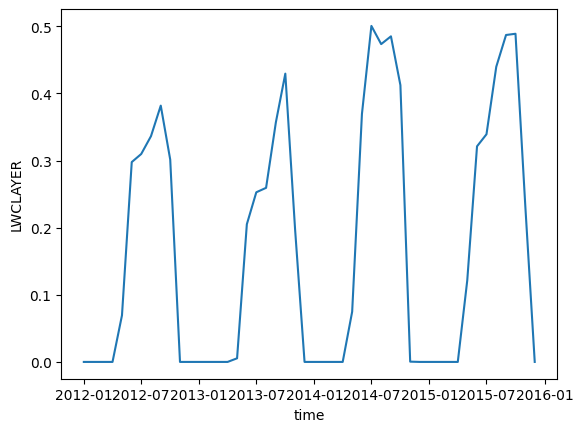

In [56]:
sns.lineplot(data=data, x='time', y='LWCLAYER')

In [61]:
### loop through the list of depths of reference to compute the soil variable at that depth via linear interpolation
stdz = []
for i in range(len(depthlist)):
    dpth = depthlist[i]
    print("depth:", dpth,"m")
    # extract the top and bottom layers the closest to the depth of reference
    
    dz['diff'] = dz['z']-float(dpth)
    top = dz.loc[dz[(dz['diff'] <= 0)].groupby(['time','x','y'])['diff'].idxmax()]
    bot = dz.loc[dz[(dz['diff'] >= 0)].groupby(['time','x','y'])['diff'].idxmin()]
    #print(bot['z'])
    
    # select the variable value for each of these top and bottom layers
    datatop = pd.merge(data, top[['time','x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','time','x','y'])
    datatop = datatop[datatop['z'].notna()]
    datatop = datatop.rename(columns={"layer": "layertop", var: var+"top", "LAYERDZ": "dztop", "z": "ztop", "LAYERTYPE": "typetop"})
    databot = pd.merge(data, bot[['time','x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','time','x','y'])
    databot = databot[databot['z'].notna()]
    databot = databot.rename(columns={"layer": "layerbot", var: var+"bot", "LAYERDZ": "dzbot", "z": "zbot", "LAYERTYPE": "typebot"})
    # merge the data to do the linear interpolation
    datastdz = pd.merge(datatop, databot, how="outer", on=['time','x','y'])
    print(datastdz)
    datastdz.to_csv(os.path.join(outpath, 'datastdz.csv'))
    datastdz['a'] = (datastdz[var+"top"] - datastdz[var+"bot"]) / (datastdz['ztop'] - datastdz['zbot'])
    datastdz['b'] = datastdz[var+"top"] - (datastdz['a'] * datastdz['ztop'])
    datastdz[var] = (datastdz['a'] * float(dpth)) + datastdz['b']
    datastdz['z'] = float(dpth)
    datastdz['layer'] = i
    datastdz['type'] = datastdz['typebot']
    datastdz = datastdz[['time','x','y','layer','z','type',var]]
    stdz.append(datastdz)
    break

depth: 0.1 m
           time  layertop  y  x  LWCLAYERtop albers_conical_equal_area_x  \
0    1901-01-01         2  0  1     0.000000                         b''   
1    1901-02-01         2  0  1     0.000000                         b''   
2    1901-03-01         2  0  1     0.000000                         b''   
3    1901-04-01         2  0  1     0.000000                         b''   
4    1901-05-01         2  0  1     0.081896                         b''   
...         ...       ... .. ..          ...                         ...   
1375 2015-08-01         2  0  1     0.149827                         b''   
1376 2015-09-01         2  0  1     0.196575                         b''   
1377 2015-10-01         2  0  1     0.178403                         b''   
1378 2015-11-01         2  0  1     0.001083                         b''   
1379 2015-12-01         2  0  1     0.000000                         b''   

      year_x     dztop  typetop      ztop  layerbot  LWCLAYERbot  \
0     

<AxesSubplot:xlabel='time', ylabel='LWCLAYERbot'>

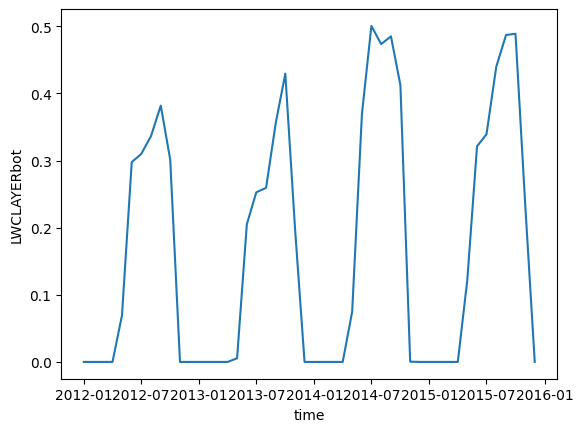

In [64]:
sns.lineplot(data=databot[databot['year']>=2012], x='time', y='LWCLAYERbot')

In [44]:
stdz = pd.concat(stdz)

stdz.to_csv(os.path.join(outpath, 'layersytnth.csv'))

In [45]:
stdz

,time,x,y,layer,z,type,LWCLAYER
0,1901-01-01,1,0,0,0.05,1.0,0.000000
1,1901-02-01,1,0,0,0.05,1.0,0.000000
2,1901-03-01,1,0,0,0.05,1.0,0.000000
3,1901-04-01,1,0,0,0.05,1.0,0.003853
4,1901-05-01,1,0,0,0.05,1.0,0.122271
...,...,...,...,...,...,...,...
1375,2015-08-01,1,0,0,0.05,1.0,0.145504
1376,2015-09-01,1,0,0,0.05,1.0,0.206726
1377,2015-10-01,1,0,0,0.05,1.0,0.135296
1378,2015-11-01,1,0,0,0.05,1.0,0.000194
